In [500]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
%matplotlib inline

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [501]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [502]:
class Lidar(object):
    def __init__(self, nbeams=8, fov=60, max_dist=5.0, sampling_pts=20):
        #nbeams = number of sensing beams
        #FOV = field-of-view of Lidar/ coverage in degrees
        #max_dist = maximum distance Lidar can sense
        #sampling_pts = num pts on a given beam for obstacle check
        self.beam_angles = np.deg2rad(np.linspace(-fov/2+np.pi/2,fov/2+np.pi/2,num=nbeams))
        self.line_sampler = max_dist * np.linspace(0, 1, num=sampling_pts)
    
    def set_env(self, grid, grid_res=0.05):
        #2-D occupancy grid and grid_resolution
        self.grid = grid
        self.grid_res = grid_res
    
    def sense_obstacles(self, pose):
        xc, yc, theta = pose
        beam_data = []
        for b in self.beam_angles:
            direction = np.array([np.cos(theta+b), np.sin(theta+b)])
            for d in self.line_sampler:
                beam_x, beam_y = np.array([xc, yc]) + d * direction
                i, j = int(beam_x/self.grid_res), int(beam_y/self.grid_res)
                if self.grid[i][j] == 1:
                    break
            beam_data.append(d)
        return beam_data

In [503]:
""" 
The code to generate the different pairs given the suitable v,w values computed
This is the same example used as in the theory lectures                         
"""
v_min, v_max = 0.9, 1.1
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=5)
ws = np.linspace(w_min, w_max, num=5)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
# print(cmd)
# print(cmd.shape)

Lets define our grid

In [504]:
r = 0.15
l = 0.15
# circles = (x coordinate, y coordinate, radius)
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

def circle_collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],
                      [np.cos(tl),  np.sin(tl)]])   # Rotational matrix
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)   # Get the actual coordinates
        rc_pix = (rc/ grid_res)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)   # Return points within the radii of the vehicle
        occupied_pt = grid[X, Y] == 1   # Get all the occupied points
        if np.sum(np.multiply( inside_circle, occupied_pt)):   # Check if those points within the radii contain any obstacles
          return True
    return False

In [505]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])   
    return poses

In [506]:
# Increasing these values for faster turn rate
# W_MAX = 5
# W_DOT_MAX = 20
# K_MAX = 3

# commands = command_window(1, 0)
# print(commands)

In [507]:
def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt) 
    # print(f" vmax: {np.round(v_max,3)} \n")  
    # above statement returns velocity after 0.1s with acc =  ACC_MAX, provided returned velocity < V_MAX, otherwise returns V_MAX
    v_min = max(0, v - ACC_MAX*dt)   
    # print(f"v_min: {np.round(v_min,3)} \n")  
    # above statement returns velocity after 0.1s with deacc =  ACC_MAX, provided returned velocity > 0, otherwise returns 0

    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    # print(f"w_max: {np.round(w_max,3)} \n")  
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    # print(f"w_min: {np.round(w_min,3)} \n")  
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=11)
    # print(f"vs: {np.round(vs,3)} \n")  
    ws = np.linspace(w_min, w_max, num=21)
    # print(f"ws: {np.round(ws,3)} \n")  

    # vs = np.linspace(v_max, v_min, num=11)
    # ws = np.linspace(w_max, w_min, num=21)


    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])   # Cartesian product
    # print(f"commands: {np.round(commands,3)} \n")  
    #calculate kappa for the set of commands  (w/v)
    epsilon = 1e-6
    #       (   w_values  ) / (     v_values + epsilon)
    kappa = (commands[:,1]) / (commands[:,0] + epsilon)  
    # epsilon is added to get rid of zero error, ie when v = 0, w/v is undefined 
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

In [508]:
def printf(a,len=3):
  print(np.round(a,len))

In [509]:
# command_try = command_window(0, 0)
# # print(f"command_try: {np.round(command_try,3)}")
# printf(command_try,3)

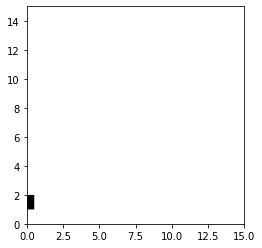

In [510]:
#custom grid
#choose resolution and dimensions
grid_res = 0.05
grid_span =  15 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
# Let 1 mean occupied, 0 mean unnoccupied
grid_data = np.zeros(grid_shape)   # Set entire map as unoccupied

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[0,0.5 , 1, 2]])
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0   

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

# base_y = 8.2
# base_x = 3.5
# local_traj = np.array([[0, 0.25, np.pi/2], [0, 1.0, np.pi/2], [0, 1.5, np.pi/2]])   # Along x = 0
# local_traj = np.array([[1, 1, np.pi/2], [1, 2, np.pi/2], [1, 3, np.pi/2]])   # Along x = 1
# local_traj = np.array([[base_x, base_y, np.pi/2], [base_x+1, base_y, np.pi/2], [base_x+2, base_y, np.pi/2]])   # Along y = 8.2

# print(circle_collision_check(grid_data, local_traj))

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
# plt.plot(local_traj[:,0], local_traj[:,1])

In [511]:
buffer = 0
# curr_pose = (8, 12, np.pi/2)
def track(ref_path, pose, v, w, dt=0.1):
    commands = command_window(v, w, dt)
    dist = lidar.sense_obstacles(pose=pose)

    # print(dist[:4])   # -ve w distances
    neg_w_distances = np.sum(dist[:4])/4
    print(f"negative distances: {neg_w_distances}")

    # print(dist[4:])   # +ve w distances
    pos_w_distances = np.sum(dist[4:])/4
    print(f"positive distances: {pos_w_distances}")

    heuristic_cost = np.abs(pos_w_distances - neg_w_distances)*10
    print(f"heuristic_cost = {heuristic_cost}")

    if pos_w_distances > neg_w_distances: 
      # heuristic_cost = pos_w_distances - neg_w_distances
      print("positive values are greater")
      collision_check = True
      pos_w, neg_w = True, False

    if neg_w_distances > pos_w_distances: 
      # heuristic_cost = neg_w_distances - pos_w_distances
      print("negative values are greater")
      collision_check = True
      pos_w, neg_w = False, True

    if neg_w_distances == pos_w_distances:
      # heuristic_cost = 0
      collision_check = False
      pos_w, neg_w = False, False

    
    print(f"\n Tracked point: {np.round(ref_path[-1][0])}, {np.round(ref_path[-1][1], 2)}")   # Print which point is being tracked
    # global grid_data
    #initialize path cost
    cte = np.inf
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        print(f"{i+1}")
        print(f"v, w = {np.round(v,3)}, {np.round(w,3)}")
        local_path = simulate_unicycle(pose, v, w, pred_horizon + buffer)   # Number of steps = prediction horizon + buffer
        final_x, final_y = local_path[-1][0], local_path[-1][1]   # Get last position
        # plt.plot(final_x, final_y, '.')

        if collision_check:
          if circle_collision_check(grid_data, local_path): #ignore colliding paths
              print("  local path has a collision \n")
              continue


        
        # calculate cross-track error
        # can use a simplistic definition of how close is the last pose in local path from the ref path
        # for x, y,_ in ref_path:
        #   point_dist = np.sqrt((x-local_path[-1][0])**2 + (y-local_path[-1][1])**2)
        #   if point_dist < cte: 
        #     cte = point_dist
        #     tracked_x, tracked_y = x, y
        #   else: continue
        # print(f"tracked: {tracked_x}, {tracked_y}")

        # closest_pt = np.argmin(np.hypot(ref_path[:path_index] - local_path[-1]))
        # print(f"  closest point: {closest_pt}")

        # Calculate distance between final ref_path point and final local_path point
        cte = np.sqrt((ref_path[-1][0]-local_path[-1][0])**2 + (ref_path[-1][1]-local_path[-1][1])**2)
        print(f"  Cross Track Error: {cte}")
        
        # heuristic_cost = np.sqrt((tracked_x-local_path[-1][0])**2 + (tracked_y-local_path[-1][1])**2)
        # other cost functions are possible
        # can modify collision checker to give distance to closest obstacle

        if neg_w and w > 0:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2  + heuristic_cost
          print("  added heuristic")

        elif pos_w and w < 0:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2  + heuristic_cost
          print("  added heuristic")
        
        else:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2
          print("  no heuristic")

        print(f"  Cost: {cost}")
        print(f"  final position: {np.round(final_x,3)}, {np.round(final_y,3)} \n")
        #check if there is a better candidate
        if cost <= best_cost:
            best_cost, best_command, sl = cost, [v, w], i+1

    # print("tracking x = ", np.round(tracked_x, 2))
    # print("tracking y = ", np.round(tracked_y, 2))
    print(f"\nBest cost: {np.round(best_cost,3)}")
    print(f"Best command: {best_command}")
    print(f"iteration: {sl}")
    # print(f"Beam distances: {dist}")
    if best_command:
        return best_command
    else:
        return [0, 0]
    # return best_command

negative distances: 0.5434210526315788
positive distances: 0.6539473684210526
heuristic_cost = 1.105263157894738
positive values are greater

 Tracked point: 0.0, 2.22
1
v, w = 0.2, -0.27
  Cross Track Error: 1.5246759800876921
  added heuristic
  Cost: 3.62993913798243
  final position: 0.034, 0.698 

2
v, w = 0.21, -0.27
  Cross Track Error: 1.5148097628416137
  added heuristic
  Cost: 3.6001729207363518
  final position: 0.035, 0.708 

3
v, w = 0.22, -0.27
  Cross Track Error: 1.5049449129352166
  added heuristic
  Cost: 3.5706080708299544
  final position: 0.037, 0.718 

4
v, w = 0.23, -0.27
  Cross Track Error: 1.4950814574344515
  added heuristic
  Cost: 3.5412446153291897
  final position: 0.038, 0.728 

5
v, w = 0.24, -0.27
  Cross Track Error: 1.4852194241203818
  added heuristic
  Cost: 3.51208258201512
  final position: 0.039, 0.738 

6
v, w = 0.25, -0.27
  Cross Track Error: 1.4753588415128205
  added heuristic
  Cost: 3.4831219994075586
  final position: 0.04, 0.747 

7
v,

<Figure size 432x288 with 0 Axes>

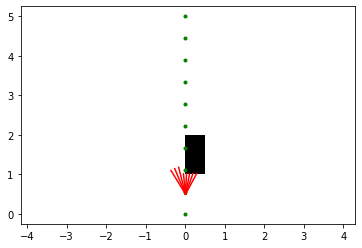

<Figure size 432x288 with 0 Axes>

In [512]:
start_pose = [ 0.01, 0.5, np.pi/2 ]
initial_pose = [0, 0, np.pi/2]
# start_pose = initial_pose
v_initial, w_initial = 1, 0
# route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
route = [("straight", 5)]
pose = start_pose
ref_path = traj(route, initial_pose).T
goal_index = 5
path_index = 0
if len(ref_path) <= goal_index:
  # print("true")
  local_ref_path = ref_path

else:
  local_ref_path = ref_path[path_index:path_index+goal_index]
  curr_x, curr_y = pose[0], pose[1]
  local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
  # update path_index using current pose and local_ref_path
  if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*10:
    path_index = path_index + 1

logs = []
path_index = 0
# v, w = 0.700, -1.200   
# v:0.500, w:-0.726
v, w = 0.25, 0.0300
# get next command
v, w = track(local_ref_path, start_pose, v, w)

# Plot 
poses = simulate_unicycle(start_pose, v, w, pred_horizon)
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
poses = np.array(poses)
plt.plot(poses[:,0], poses[:,1])
rectangle = plt.Rectangle((0,1), 0.5, 1, fc='black')   # [0,0.5 , 1, 2]
plt.gca().add_patch(rectangle)

x1, y1 = 0, 0
x2, y2 = grid_span, grid_span
# plt.figure()
# plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
# test_pose = [0, 0.5, -np.pi/2]
x, y, theta = start_pose
dist = lidar.sense_obstacles(pose=start_pose)
print(f"Beam distances: {dist}")
for b, tprime in zip(dist, lidar.beam_angles):
    t = tprime+theta
    plt.plot((x, x+b*np.cos(t)),(y, y+b*np.sin(t)),'r-')
plt.figure()




<Figure size 432x288 with 0 Axes>

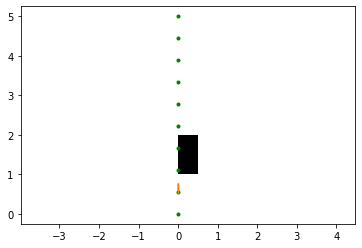

<Figure size 432x288 with 0 Axes>

In [513]:
# Plot 
# plt.plot(0.972, 0.615 , 'x')
# plt.plot(0.98, 0.611, 'x')
# plt.plot(0.43, 0.87, 'x', c='r')

poses = simulate_unicycle(start_pose, v, w, pred_horizon)
plt.axes().set_aspect('equal', 'datalim')
poses = np.array(poses)
plt.plot(poses[:,0], poses[:,1])

plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')

rectangle = plt.Rectangle((0,1), 0.5, 1, fc='black')   # [0,0.5 , 1, 2]
plt.gca().add_patch(rectangle)

# Plot test trajectory
test_poses = simulate_unicycle(start_pose,0.25, 0.0300, pred_horizon)
test_poses = np.array(test_poses)
plt.plot(test_poses[:,0], test_poses[:,1])

plt.figure()

231 

v, w = 0.75, -1.0 

  Cross Track Error: 1.9050234106315562
   
   Cost: 2.1075234106315563
  
   final position: 1.125, 0.685 

In [514]:
poses = simulate_unicycle(start_pose, 0.75, 0.8, pred_horizon)
# print(np.round(poses,3))
printf(poses)

[[ 0.01   0.575  1.651]
 [ 0.004  0.65   1.731]
 [-0.008  0.724  1.811]
 [-0.026  0.797  1.891]
 [-0.049  0.868  1.971]
 [-0.079  0.937  2.051]
 [-0.113  1.003  2.131]
 [-0.153  1.067  2.211]
 [-0.198  1.127  2.291]
 [-0.247  1.184  2.371]]


In [515]:
# dist = lidar.sense_obstacles(pose=start_pose)
# print(dist)
# print(dist[:4])   # -ve w distances
# neg_w_distances = np.sum(dist[:4])/4
# print(neg_w_distances)
# print(dist[4:])   # +ve w distances
# pos_w_distances = np.sum(dist[4:])/4
# print(pos_w_distances)
# if pos_w_distances >neg_w_distances:
#   heuristic_cost = pos_w_distances - neg_w_distances 
# print(heuristic_cost)

In [516]:
# xc, yc = 0.0, 4.76
# print(ref_path[-1][0], ref_path[-1][1])
# print(ref_path)

In [517]:
# poses = np.array(logs)[:,:3]
# plt.figure()
# plt.axes().set_aspect('equal', 'datalim')
# plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
# plt.plot(poses[:,0], poses[:,1], c='r')
# print(actual_path[:,0], actual_path[:,1])

# Plot obstacle
# rectangle = plt.Rectangle((0,1), 0.5, 1, fc='black')   # [0,0.5 , 1, 2]
# plt.gca().add_patch(rectangle)

# plt.plot(1.020538999289461e-16, 1.6666666666666665, '.')
# plt.plot(6.803593328596407e-17, 1.1111111111111112, '.')

Now it should be relatively straight-forward to integrate collision checking in the grid environment the robot is going to navigate

In [518]:
# start_pose = (0, 0, np.pi/2)
# poses = simulate_unicycle(start_pose, 1, 0, pred_horizon)
# # print(poses)
# # print(poses[0][0])
# plt.axes().set_aspect('equal', 'datalim')


# poses = np.array(poses)
# plt.plot(poses[:,0], poses[:,1])
# plt.figure()

In [519]:
# print(actual_path)
# print(np.array(poses))
# print(command_window(0.7,0))

In [520]:
# start_pose = (0, 0, np.pi/2)
# plt.axes().set_aspect('equal', 'datalim')
# commands = np.array(command_window(0.7, 0))
# poses = np.array(simulate_unicycle(start_pose, 1, 0, pred_horizon))
# print(len(commands))
# # plt.plot(poses[:,0], poses[:,1])
# plt.figure()
# for v, w in commands:
#   # print(v, w)
#   poses = np.array(simulate_unicycle(start_pose, v, w, pred_horizon))
#   plt.plot(poses[:,0], poses[:,1])

# plt.figure()


In [521]:
# # start_pose = np.array([0, 0, np.pi/2])
# start_pose = [0, 0, np.pi/2]
# route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
# # route = [("straight", 5)]
# ref_path = traj(route, start_pose).T
# # actual_path = ref_path
# # ref_path = ref_path[1:][:]   # Remove the first point

# pose = start_pose
# logs = []
# path_index = 0
# v, w = 0.0, 0.0
# iterations = 1
# # while path_index < len(ref_path):
# # print(np.sqrt((ref_path[-1][0]-pose[0])**2 + (ref_path[-1][1]-pose[1])**2))
# # print(ref_path[-1][1])
# # print(pose[1])
# # goal_error = np.sqrt((ref_path[-1][0]-pose[0])**2 + (ref_path[-1][1]-pose[1])**2)
# while np.sqrt((ref_path[-1][0]-pose[0])**2 + (ref_path[-1][1]-pose[1])**2) > goal_threshold*3:
#     print(f"iteration: {iterations}")
#     t0 = time.time()
#     if(len(ref_path)<=10):
#       local_ref_path = ref_path

#     else:
#       local_ref_path = ref_path[path_index:path_index+pred_horizon]
#     # local_ref_path = ref_path
#     # print(np.round(local_ref_path,3))
#       curr_x, curr_y = pose[0], pose[1]
#       local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
#       # update path_index using current pose and local_ref_path
#       if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*10:
#         path_index = path_index + 1

#     # get next command
#     v, w = track(local_ref_path, pose, v, w)
    
#     #simulate vehicle for 1 step
#     # remember the function now returns a trajectory, not a single pose
#     pose = simulate_unicycle(tuple(pose), v, w)
#     pose = pose[0]

#     print(f" {np.round(pose[0],2)}, {np.round(pose[1],2)}, {np.round(pose[2], 2)} ")

#     # if(pose[2] < np.pi/10): break
#     #update logs
#     logs.append([*pose, v, w])
#     t1 = time.time() #simplest way to time-profile your code
#     print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms \n")
#     iterations = iterations+1
# # print(pose)
# # print(iterations)

In [522]:
# import csv

# # name of csv file 
# filename = "collision.csv"
    
# # writing to csv file 
# with open(filename, 'w') as csvfile: 
#     # creating a csv writer object 
#     csvwriter = csv.writer(csvfile) 
        
#     # writing the fields 
#     csvwriter.writerow(poses) 
        
#     # writing the data rows 
#     # csvwriter.writerows(rows)

In [523]:
# filename = "collision.csv"
  
# # reading csv file
# with open(filename, 'r') as csvfile:
#     # creating a csv reader object
#     csvreader = csv.reader(csvfile)
      
#     # extracting field names through first row
#     qwerty = next(csvreader)
  
#     # extracting each data row one by one
#     # for row in csvreader:
#     #     rows.append(row)
  
#     # get total number of rows
#     # print("Total no. of rows: %d"%(csvreader.line_num))
# print(qwerty)
# # print(list(qwerty))
# qwerty = np.array(qwerty)
# print(qwerty[1][0])
# plt.figure()
# plt.plot(qwerty[:,0], qwerty[:,1], c='r')